# Carga de librerías y datos

In [1]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm


CUSTOM_FORMAT = {"with_labels" : False,
                "node_size": 20, "node_color": "#ff0000", "edgecolors": "#911a07",
                "width": 0.4, "edge_color": "black"}

dolphins = nx.read_gml("datasets/dolphins.txt")
genders = pd.read_csv("datasets/dolphinsGender.txt", delimiter = "\t", header = None, names = ["ID", "Gender"])

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
genders.set_index("ID", inplace = True)
genders = pd.Series(genders["Gender"])

#Agregamos el atributo de sexo a cada nodo
for i in dolphins.nodes: 
    dolphins.nodes[i]["Gender"] = genders[i]
#Por lo que ahora podemos acceder al genero de cada delfin como dolphins.nodes[ID]["Gender"]

# A) Visualización de la red

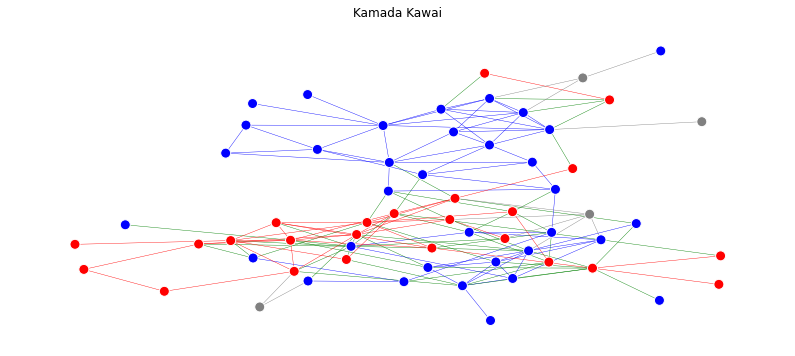

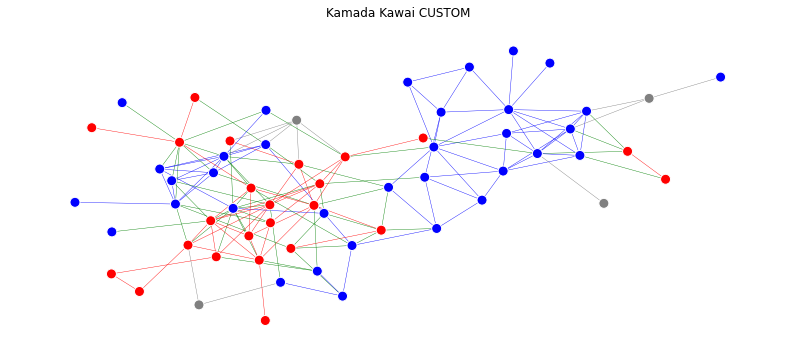

In [9]:
def layouts(graph):
    return {
     #"Spring": nx.layout.spring_layout(graph, seed=42),
     "Kamada Kawai": nx.layout.kamada_kawai_layout(graph),
     "Kamada Kawai CUSTOM": nx.layout.kamada_kawai_layout(graph, pos = nx.layout.random_layout(graph, seed=42)),
     #"Random": nx.layout.random_layout(graph, seed=42),
     #"Shell": nx.layout.shell_layout(graph),
     #"Spectral": nx.layout.spectral_layout(graph),
     #"Spiral": nx.layout.spiral_layout(graph)
    }

edge_homophility = [genders.loc[i[0]] == genders.loc[i[1]] for i in dolphins.edges]

for k, l in layouts(dolphins).items():
    fig, ax = plt.subplots(1, 1, figsize = (14, 6))
    nx.draw(
            dolphins, 
            with_labels=False, 
            node_size=100, 
            edgecolors="white",
            width=0.4, 
            node_color=["red" if dolphins.nodes[node]["Gender"] == "f" 
                          else ("blue" if dolphins.nodes[node]["Gender"] == "m" else "gray") 
                          for node in dolphins.nodes],

            edge_color=["red" if (h and  genders.loc[i[0]] == "f")
            else "blue" if (h and  genders.loc[i[0]] == "m")
            else "green" if (genders.loc[i[0]] == "f" and genders.loc[i[1]] == "m") or (genders.loc[i[0]] == "m" and genders.loc[i[1]] == "f")
            else "gray" 
            for i,h in zip(dolphins.edges, edge_homophility)],
            pos=l)
    ax.set_title(k)
    plt.show()

# B) i) Calculo de homofilia y comparación con distribuciones aleatorias

In [4]:
def get_homophily(series, graph):
    homo_edges = [series.loc[i[0]] == series.loc[i[1]] for i in graph.edges]
    homophily = sum(homo_edges)/len(homo_edges)
    return homophily

def shuffle_series(series: pd.Series, seed: int = 42) -> pd.Series:
    """
    Shuffle a given series.
    """
    idx = series.index
    series_mod = series.sample(frac=1.0, random_state= seed, )
    series_mod.index = idx
    return series_mod

In [5]:
#Conseguimos la homofilia de la red original.
homophily = get_homophily(genders, dolphins)
homophily

0.6037735849056604

In [19]:
def parallel_homophily(s):

    #Mezclamos los generos y copiamos la red para no transformarla.
    shuffled_genders = shuffle_series(genders, seed=s)
    dolphins_copy = dolphins.copy()

    #Cambiamos los generos de la copia de dolphins con los mezclados.
    for i in dolphins_copy.nodes: 
        dolphins_copy.nodes[i]["Gender"] = shuffled_genders[i]
    return get_homophily(shuffled_genders, dolphins_copy)


num_muestras = 1e6
try:
    h = np.load("{num_muestras} iters.npy")
except FileNotFoundError:
    df_parallel = pd.DataFrame({"seed":[i for i in range(num_muestras)]})
    df_parallel_homophily = df_parallel.copy()
    df_parallel_homophily["homophily"] = df_parallel["seed"].parallel_apply(parallel_homophily)
    h = df_parallel_homophily["homophily"].to_numpy()
    np.save(f"{num_muestras} iters.npy", h)

In [22]:
num_muestras = 1e6
h = df_parallel_homophily["homophily"].to_numpy()
np.save(f"{num_muestras} iters.npy", h)

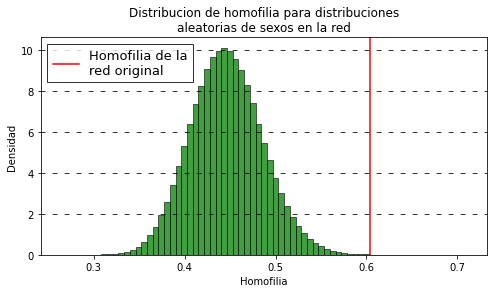

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(h, color="green", stat="density", bins = 71)
plt.title("Distribucion de homofilia para distribuciones\naleatorias de sexos en la red")
plt.ylabel("Densidad")
plt.xlabel("Homofilia")
plt.grid(axis="y", linestyle=(1, (6, 9)), color="black")
plt.axvline(homophily, color="red", label="Homofilia de la\nred original")
plt.legend(fancybox=False, edgecolor="black", fontsize=13)
plt.show()

In [31]:
len(df_parallel_homophily[df_parallel_homophily["homophily"] > homophily])/num_muestras

0.00012

### Calculo el promedio y la desviacion estandar

In [52]:
print(f"El promedio de la homofilia es {h.mean():.3f} ± {h.std(ddof=1):.3f}")

El promedio de la homofilia es 0.442 ± 0.040


### Solucion numerica de la estimacion del valor medio esperado

In [64]:
N = 1000000
coincide = 0
for i in range(N):
    random_sample = genders.sample(2)
    if random_sample.iloc[0] == random_sample.iloc[1]:
        coincide += 1
coincide/N

0.442539

In [65]:
N = genders.size
male, female = genders.value_counts().to_numpy()
h_expected = (male*(male-1) + female*(female-1))/(N*(N-1))
h_expected

0.4426229508196721